# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Visual examination of correlations

Matplotlib setup.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Do survey responses correlate with SAT scores?

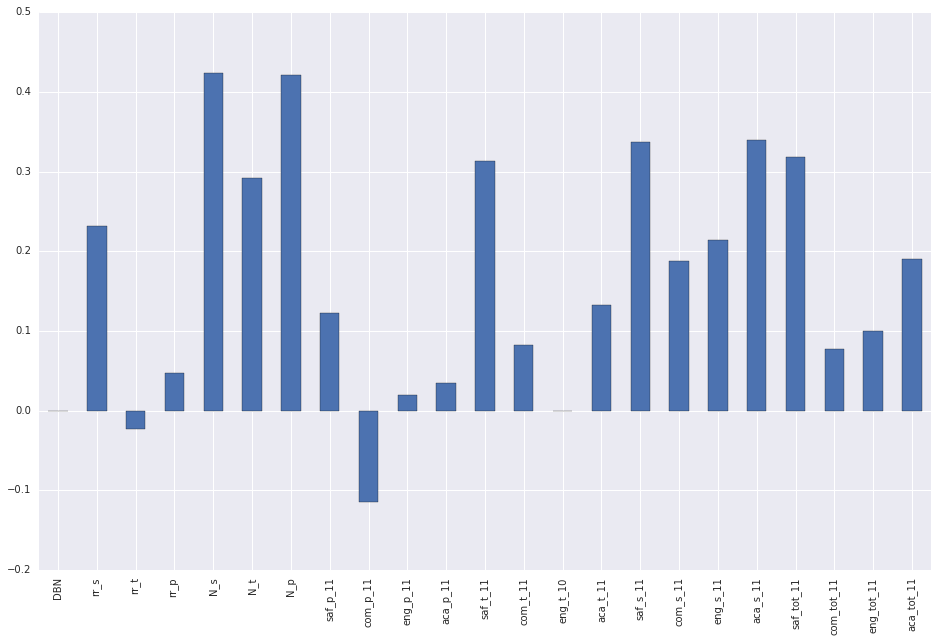

In [21]:
correlations[survey_fields].plot.bar(figsize = (16,10))

## Key to apparently correlated values:

N_s = Number of student respondents

N_t = Number of teacher respondents

N_p = Number of parent respondents


saf_t_11 - Safety and Respect score based on teacher responses

saf_s_11 - Safety and Respect score based on student responses

saf_tot_11 - Safety and Respect total score


aca_s_11 - Academic expectations score based on student responses

## Observations

1. Number of parent and student responses have the highest positive correlations - potentially indicating that schools where the parent and student populations are more likely to engage with a survey are likely to have higher SAT averages.

2. Out of the scores given, Safety and Respect are the most highly correlated, and students and teachers responses to this survey question appear more relevant than parent responses.

3. Interesting to note that the only Academic Expectation score that has a correlation over .25 comes from student responses.

# Investigating Safety and Respect scores

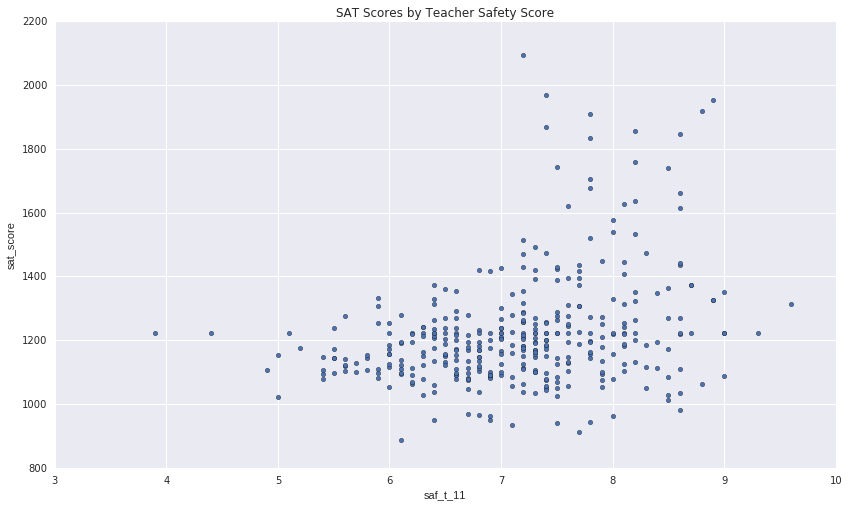

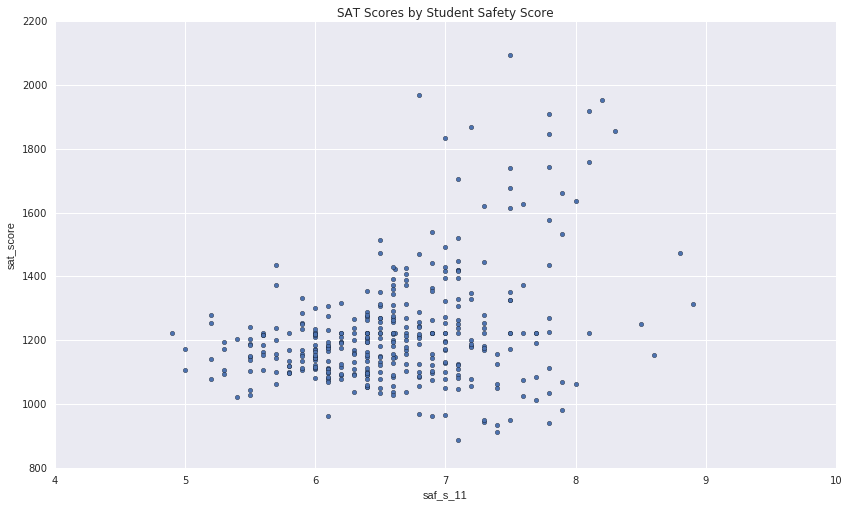

In [22]:
combined.plot.scatter(y="sat_score", x="saf_t_11", figsize=(14,8), title="SAT Scores by Teacher Safety Score")
combined.plot.scatter(y="sat_score", x="saf_s_11", figsize=(14,8), title="SAT Scores by Student Safety Score")

## Observations:
1. There does in fact appear to be a correlation between safety scores and SAT scores. This is particularly noticeable in the plot of the student scores.
2. None of the schools with lower than a ~6.5 safety score from the student population are above a ~1500 average SAT score.
3. None of the schools with lower than a ~7.2 safety score from the teacher surveys are above a ~1400 average SAT score.
4. One can infer from this that providing safety and respect for students are creating an environment where students can perform better on the SAT. Another potential explanation - priveleged students with better access to learning materials will also be in schools that feel safer. See next section for mapping of districts by safety score and average income.

# Mapping districts by safety scores

### Compute average safety scores by district (student and teacher scores)

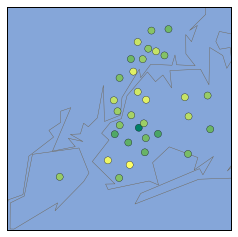

In [72]:
import numpy
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
districts["combined_s_t"] = (districts["saf_s_11"] + districts["saf_t_11"]) / 2

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i',
)

# m.readshapefile('/home/alexs/docs/data_projects/nyc_satdata/shapefiles/nysd', 'nysd', drawbounds=True)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c = districts['combined_s_t'], cmap='summer')
plt.show()

# Race and SAT Scores

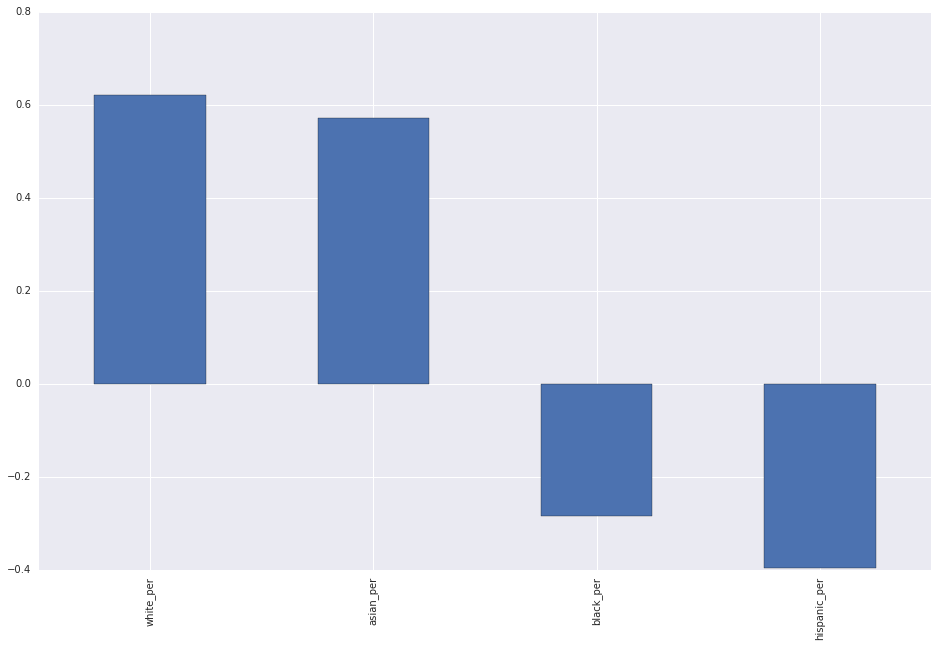

In [26]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]

correlations[race_fields].plot.bar(figsize = (16,10))

## Observations
1. A clear correlation exists between ethinicity and SAT scores. Strongest is the positive correlation for white and asian students, and the negative for hispanic students.
2. Given that the 2 negatively correlated ethinicities are black and hispanic and hispanic is a stronger correlation - is language a factor? Or more specifically, language spoken in the home?

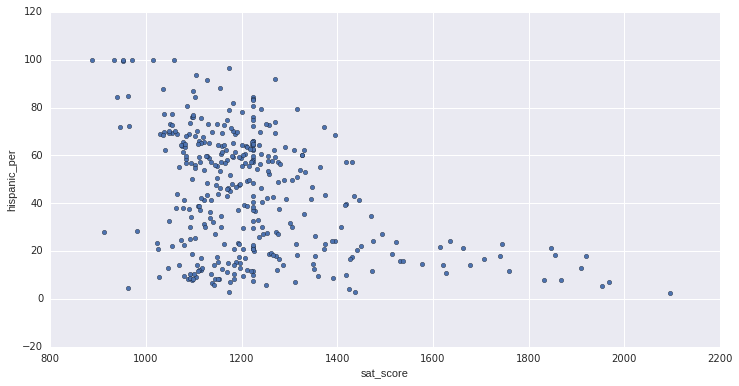

In [32]:
hisp_scatter = combined[["sat_score", "hispanic_per"]]
hisp_scatter.plot(kind="scatter", x="sat_score", y="hispanic_per", figsize = (12,6))

The suggested correlation is even more pronounced in the scatter plot above. Dropoff starts at a 1400 average, and by ~1500 the percentage of hispanic students in the school is < 25% across the board.

## Digging deeper
What schools have a high hispanic population (> 95%)? What else do they have in common?

In [36]:
high_hisp = combined[combined["hispanic_per"] >= 95]
high_hisp[["school_name","school_dist","black_per", "asian_per", "white_per", "hispanic_per"]]

,school_name,school_dist,black_per,asian_per,white_per,hispanic_per
44,Manhattan Bridges High School,02,0.0,0.2,0.0,99.8
82,Washington Heights Expeditionary Learning School,06,2.3,0.0,0.3,96.7
89,Gregorio Luperon High School for Science and M...,06,0.0,0.0,0.0,99.8
125,Academy for Language and Technology,09,0.6,0.0,0.0,99.4
141,International School for Liberal Arts,10,0.0,0.2,0.0,99.8
176,Pan American International High School at Monroe,12,0.0,0.0,0.0,99.8
253,Multicultural High School,19,0.2,0.0,0.0,99.8
286,Pan American International High School,24,0.0,0.0,0.0,100.0


It is interesting to note that these schools are almost all focused on either international students or bilingual students who have recently immigrated to the United States. While the majority does seem hispanic, a cursory examination of the schools websites does not indicate that the hispanic majorities are as high a percentage as the data would indicate. Potential for ethnicities that do not fit the four listed categories end up in the hispanic percentage?

For the other side of the spectrum - what schools have a low hispanic population and unusually high SAT averages (> 1800)?

In [38]:
low_hisp = combined[combined["hispanic_per"] <= 10]
highsat_lowhisp = low_hisp[low_hisp["sat_score"] >= 1800]
highsat_lowhisp[["school_name","school_dist","black_per", "asian_per", "white_per", "hispanic_per"]]

,school_name,school_dist,black_per,asian_per,white_per,hispanic_per
37,Stuyvesant High School,02,1.2,72.1,23.7,2.4
151,Bronx High School of Science,10,3.5,63.5,25.4,7.2
187,Brooklyn Technical High School,13,10.2,60.3,21.3,7.9
327,Queens High School for the Sciences at York Co...,28,10.5,74.4,6.7,7.9
356,Staten Island Technical High School,31,1.1,31.8,61.3,5.3


These schools are all very focused on science, technology, and math skills. The have a high percentage of asian students - the data does not allow for deeper dive in to first vs. successive generation immigrant status of students, but this could be an interesting area to dig deeper.

The exception is Staten Island Technical High School - with a 61% white student population, I would venture to guess that Staten Island is primarily white in the first place. Further investigation and mapping of population averaged required to verify and explore this statement further.

Viewed through the hispanic population lens, it is clear the SAT favors white and asian students. The 'why' deserves further investigation. Current hypothesis:
* English language - first or second language? What language is spoken at home?
* Environment - do the safety scores and the ethnic make up of the student population have a relationship? Does this effect the student's ability to study or focus?
* Teacher quality - where do the best teachers go? This of course assumes that the best teachers result in the best SAT scores. Not an assumption I am willing to make out of hand.

Clearly there are a number of factors at play - one important question that should be asked is exactly what SAT scores demonstrate. General proficiency? Knowledge absorption or rote memorization? Problem solving?

## SAT Scores and Gender

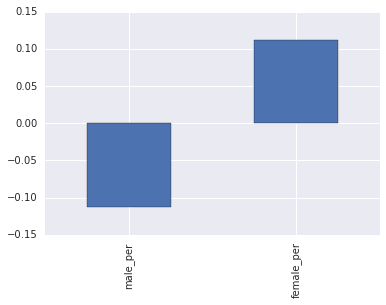

In [51]:
correlations[["male_per","female_per"]].plot.bar()

At first glance there appears to be no strong correlation (>.25) between gender and sat score.

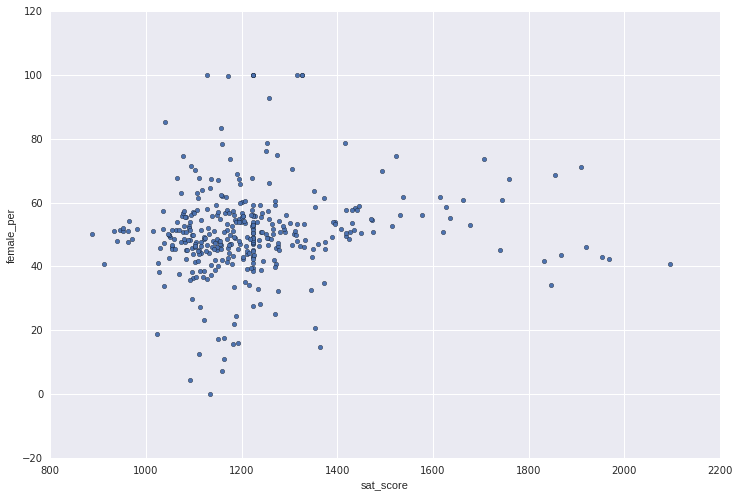

In [52]:
combined.plot(kind="scatter", x="sat_score", y="female_per", figsize=(12,8))

The outliers in this scatter plot seem the most interesting to me - schools that are completely one gender or the other do not get past the 1400 average SAT mark, but all-female schools do have a higher average than the more heavily male schools.

In [53]:
fem_high = combined[combined["female_per"] >= 60]
fem_high = combined[combined["sat_score"] >= 1700]
fem_high[["school_name","school_dist"]]

,school_name,school_dist
5,Bard High School Early College,01
26,Eleanor Roosevelt High School,02
37,Stuyvesant High School,02
60,Beacon High School,03
61,Fiorello H. LaGuardia High School of Music & A...,03
79,"High School for Mathematics, Science and Engin...",05
151,Bronx High School of Science,10
155,High School of American Studies at Lehman College,10
187,Brooklyn Technical High School,13
198,"Brooklyn Latin School, The",14


In [54]:
highsat_lowhisp[["school_name","school_dist"]]

,school_name,school_dist
37,Stuyvesant High School,02
151,Bronx High School of Science,10
187,Brooklyn Technical High School,13
327,Queens High School for the Sciences at York Co...,28
356,Staten Island Technical High School,31


## Observations
I bring back the high SAT score, low hispanic population chart here to highlight the fact that every single school on that list also has a higher than 60% female population. Again, in the high SAT score schools we see the trend toward technical and science focused schools.

# Alternative tests - AP scores (and test takers) vs SAT scores

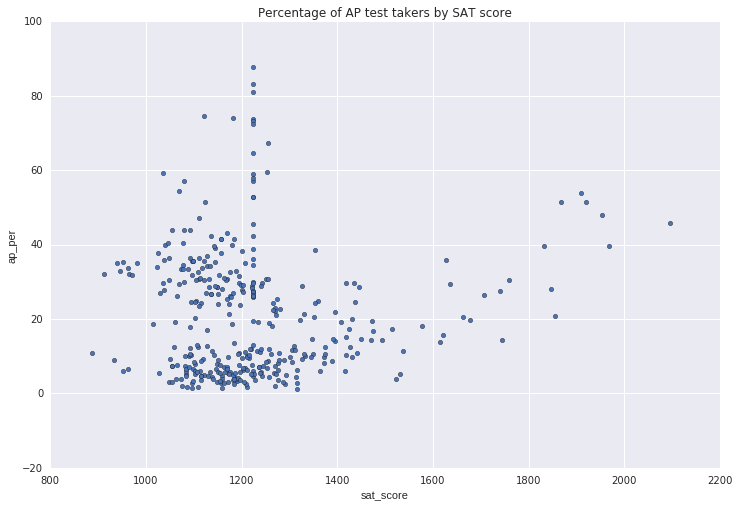

In [65]:
combined["ap_per"] = (combined["AP Test Takers "] / combined["total_enrollment"]) * 100
combined.plot(kind = "scatter", x="sat_score", y="ap_per", figsize=(12,8), title="Percentage of AP test takers by SAT score")

There appears to be a fairly strong correlation between percentage of AP test takes and the school average SAT score. However, the sharp line of points just above 1200 is suspect.

### Does the percentage of passing scores on the AP test relate to the SAT average?

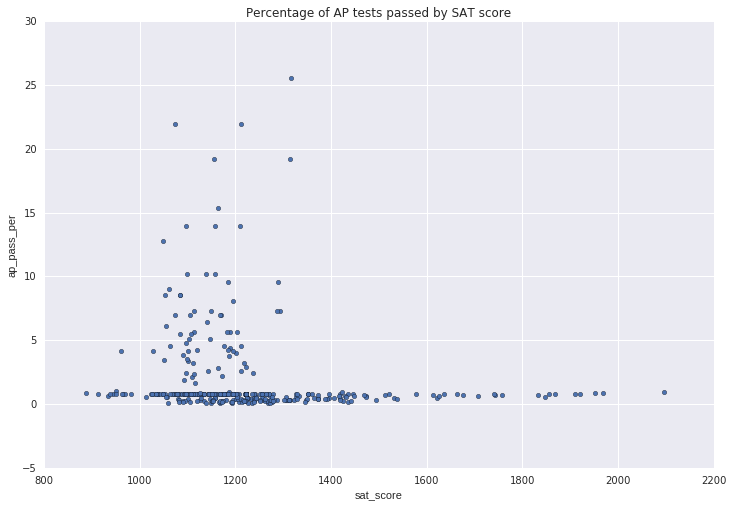

In [71]:
combined["ap_pass_per"] = (combined["Number of Exams with scores 3 4 or 5"] / combined["Total Exams Taken"])
combined.plot(kind = "scatter", x="sat_score", y="ap_pass_per", figsize=(12,8), title="Percentage of AP tests passed by SAT score")

## Observations

While there is a correlation between the number AP tests taken and the SAT score average, there does not exist the same correlation in *passed* that I would expect. Does this indicate that the AP exams are more difficult than the SAT? It would make sense that they are more specific, and being that the test does grant college credits when passed, should be more difficult questions.

My main takeaway from this section is that if more students are in a position and have the desire to take the AP courses, then there is a higher likelihood for a high SAT average. That said, there are outliers in the first plot that do bear further investigation.

# Summary

After investigation into the correlations between race, gender, safety scores (from parents, students, and teachers), and AP test takers, the following high level conclusions can be drawn:
1. Schools with a high percentage of hispanic students have a lower average SAT score.
2. A high asian population is a good indicator that a school will have a high average SAT score.
3. A high safety score from teachers and students is correlated with a high average SAT score.
4. Gender has no noticeable correlation with SAT score. However, top performing, low hispanic population schools do tend to have a female population over 60%.
5. There is a correlation between the percentage of AP test takers in a school and a higher SAT score, but the percentage of passing tests does not seem to have an effect.